In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import needed libraries

import os
import torch
import sys
import pandas as pd
import importlib

!pip install optuna
import optuna
import pickle
import matplotlib.pyplot as plt
import json
import numpy as np
from ast import literal_eval
from collections import OrderedDict
import warnings
import seaborn as sns

!pip install tensorboardX

In [15]:
os.chdir('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI') # modify cwd to your base directory

In [16]:
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [17]:
# Append the directory containing 'data_sampler' and 'ex2vec' to Python's search path
sys.path.append('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI')

# imports modules for preparing data and for training/evaluating the ex2vec model
#import data_sampler
from data_sampler import evaluate_data, get_rel_int_dict, update_rel_int_dict
from ex2vec import Ex2VecEngine
import ex2vec

#import dir of gru4rec_pytorch module to python path in order to be able to access GRU4Rec model class to be able to load it
sys.path.append('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork')
import gru4rec_pytorch
from evaluation import batch_eval

The size of the training set is: 1106989
The size of the validation set is: 156748
The size of the test set is: 320078
The size of the combined (train+val) set is: 1263737


## Ex2Vec Figure 1 (pp. 974)

In [4]:
processed = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/new_release_stream.csv')

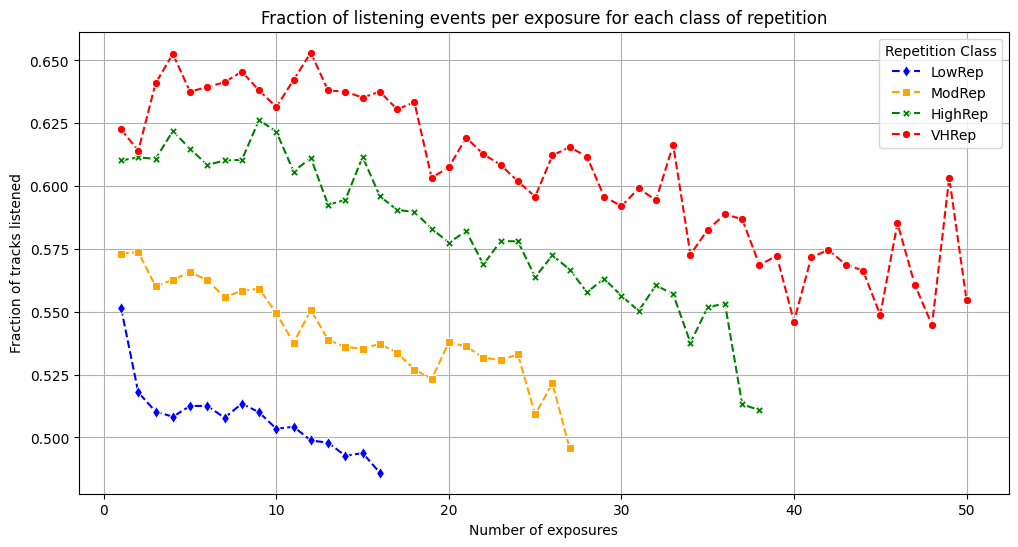

In [5]:
# count reps for each user-item pair and merge info back into the table
repetition_counts = processed.groupby(['userId', 'itemId']).size().reset_index(name='total_reps')
processed = pd.merge(processed, repetition_counts, on=['userId', 'itemId'], how='left')

# discretize rep classes according to ex2vec paper, section 3.2
def categorize_repetitions(total_reps):
    if 5.0 <= total_reps <= 16.0:
        return 'LowRep'
    elif 17.0 <= total_reps <= 27.0:
        return 'ModRep'
    elif 28.0 <= total_reps <= 38.0:
        return 'HighRep'
    elif 39.0 <= total_reps <= 100.0:
        return 'VHRep'
    else:
        return None

processed['repetition_class'] = processed['total_reps'].apply(categorize_repetitions)

# remove rows where rep class is null
processed_filtered = processed[processed['repetition_class'].notnull()]

# counter for the reps
processed_filtered['exposure'] = processed_filtered.groupby(['userId', 'itemId']).cumcount() + 1

# calculate the average listened fraction per repetition class and exposure
exposure_stats = processed_filtered.groupby(['repetition_class', 'exposure'])['y'].mean().reset_index()

# plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=exposure_stats[exposure_stats['repetition_class'] == 'LowRep'],
             x='exposure', y='y', label='LowRep', marker='d', color='blue', linestyle='--')

sns.lineplot(data=exposure_stats[exposure_stats['repetition_class'] == 'ModRep'],
             x='exposure', y='y', label='ModRep', marker='s', color='orange', linestyle='--')

sns.lineplot(data=exposure_stats[exposure_stats['repetition_class'] == 'HighRep'],
             x='exposure', y='y', label='HighRep', marker='X', color='green', linestyle='--')

sns.lineplot(data=exposure_stats[exposure_stats['repetition_class'] == 'VHRep'],
             x='exposure', y='y', label='VHRep', marker='o', color='red', linestyle='--')

plt.xlabel('Number of exposures')
plt.ylabel('Fraction of tracks listened')
plt.title('Fraction of listening events per exposure for each class of repetition')
plt.grid(True)
plt.legend(title='Repetition Class', loc='upper right')


plt.show()

## Ex2Vec Figure 2 a (pp. 974)

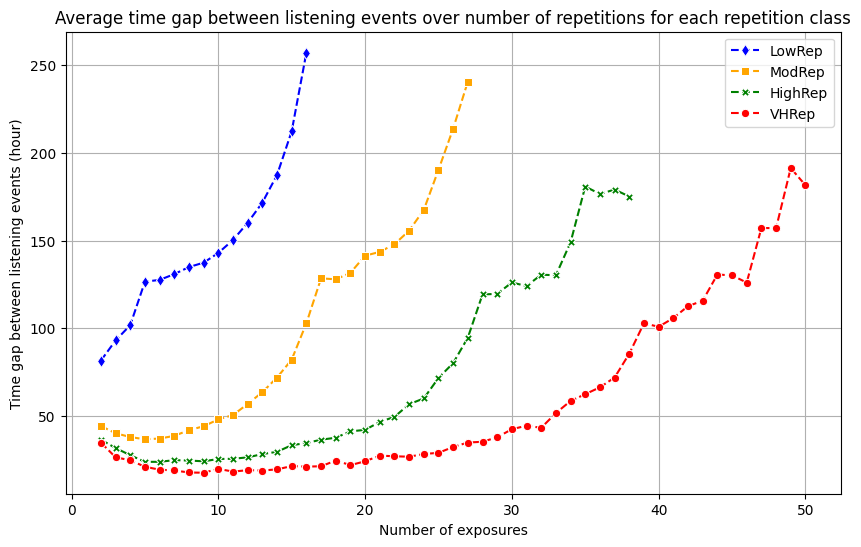

In [6]:
# Sort by user, item, and timestamp to ensure correct order for calculating time differences
processed_filtered = processed_filtered.sort_values(by=['userId', 'itemId', 'timestamp'])

# Calculate the time difference between repetitions (in hours)
processed_filtered['time_between_hours'] = processed_filtered.groupby(['userId', 'itemId'])['timestamp'].diff() / 3600

# drop nan value rows
processed_filtered.dropna(subset=['time_between_hours'], inplace=True)

# Group by 'repetition_class' and 'exposure', calculate the average time between repetitions
avg_time_between = processed_filtered.groupby(['repetition_class', 'exposure'])['time_between_hours'].mean().reset_index()


plt.figure(figsize=(10, 6))

sns.lineplot(data=avg_time_between[avg_time_between['repetition_class'] == 'LowRep'],
             x='exposure', y='time_between_hours', label='LowRep', marker='d', color='blue', linestyle='--')

sns.lineplot(data=avg_time_between[avg_time_between['repetition_class'] == 'ModRep'],
             x='exposure', y='time_between_hours', label='ModRep', marker='s', color='orange', linestyle='--')

sns.lineplot(data=avg_time_between[avg_time_between['repetition_class'] == 'HighRep'],
             x='exposure', y='time_between_hours', label='HighRep', marker='X', color='green', linestyle='--')

sns.lineplot(data=avg_time_between[avg_time_between['repetition_class'] == 'VHRep'],
             x='exposure', y='time_between_hours', label='VHRep', marker='o', color='red', linestyle='--')

plt.title('Average time gap between listening events over number of repetitions for each repetition class')
plt.xlabel('Number of exposures')
plt.ylabel('Time gap between listening events (hour)')
plt.grid()
plt.legend(loc='upper right')

plt.show()

## Ex2Vec Figure 3 (without GRU4Rec item embds), baseline

In [18]:
# convert best parameters to parameter string
def convert_to_param_str(best_param_path):
  with open(best_param_path, 'r') as f:
    data = json.load(f)

  params = data['best_params'] # extract only the parameter part
  param_str = ','.join([f'{key}={value}' for key,value in params.items()])

  return param_str

In [28]:
# load ex2vec best parameters and use them as config
ex2vec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/baseline_params_ex2vec.json')
ex2vec_config = OrderedDict([x.split('=') for x in ex2vec_best_param_str.split(',') if "=" in x])

config = config = {
    "alias": 'ex2vec_baseline_finaltrain_DEL',
    "num_epoch": int(ex2vec_config['num_epoch']),
    "batch_size": int(ex2vec_config['batch_size']),
    "optimizer": 'adam',
    "lr": float(ex2vec_config['learning_rate']),
    "rmsprop_alpha": float(ex2vec_config['rmsprop_alpha']),
    "momentum": float(ex2vec_config['momentum']),
    "n_users": 3623,
    "n_items": 879,
    "latent_dim": 64,
    "num_negative": 0,
    "l2_regularization": float(ex2vec_config['l2_regularization']),
    "use_cuda": True,
    "device_id": 0,
    "pretrain": True,
    "pretrain_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/ex2vec_baseline_FULL__BS512LR5e-05L_DIM64N_EP100_Epoch99_f10.6521.pt",
    "model_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt",
    "chckpt_dir":"/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt",
}

# instantiate ex2vec model and set to eval mode for inference
ex2vec_pre_baseline = Ex2VecEngine(config, '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/')
ex2vec_pre_baseline.model.eval()

/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/ex2vec.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ex2vec_pre.load_state_dict(torch.load(config['pretra

Ex2Vec(
  (user_lamb): Embedding(3623, 1)
  (user_bias): Embedding(3623, 1)
  (item_bias): Embedding(879, 1)
  (embedding_user): Embedding(3623, 64)
  (embedding_item): Embedding(879, 64)
  (logistic): Sigmoid()
  (tanh): Tanh()
)

In [21]:
test_data_path = '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/processed.csv'
test_data = pd.read_csv(test_data_path, sep=',', converters={"relational_interval": literal_eval})

In [22]:
test_data = test_data[test_data['set'] == 'test']
users, items, rel_ints = test_data['userId'].tolist(), test_data['itemId'].tolist(), test_data['relational_interval'].tolist()

# pad relational_intervals with -1 until length 50 (according to paper)
padded_rel_ints = [np.pad(rel_int, (0, 50-len(rel_int)), constant_values=-1) for rel_int in rel_ints]

# get scores and distances
interests_baseline, distances_baseline = ex2vec_pre_baseline.model(torch.tensor(users).cuda(), torch.tensor(items).cuda(), torch.tensor(padded_rel_ints).cuda())

<ipython-input-22-5bb142849a1f>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  interests, distances = ex2vec_pre.model(torch.tensor(users).cuda(), torch.tensor(items).cuda(), torch.tensor(padded_rel_ints).cuda())


Text(0.5, 1.0, 'Interest over different $d_{u,i}$ (Ex2Vec item embeddings)')

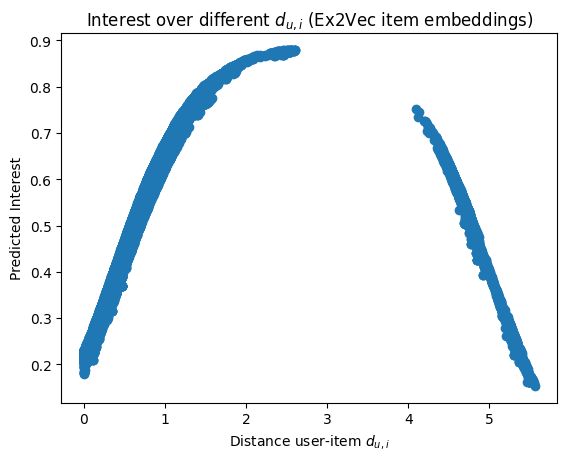

In [30]:
plt.scatter(distances_baseline.detach().cpu().numpy(), interests_baseline.detach().cpu().numpy())

plt.ylabel('Predicted Interest')
plt.xlabel('Distance user-item $d_{u,i}$')
plt.title('Interest over different $d_{u,i}$ (Ex2Vec item embeddings)')

## Ex2Vec Figure 3 (without GRU4Rec item embds), finaltrain

In [20]:
# load ex2vec best parameters and use them as config
ex2vec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json')
ex2vec_config = OrderedDict([x.split('=') for x in ex2vec_best_param_str.split(',') if "=" in x])

config = config = {
    "alias": 'ex2vec_baseline_finaltrain_DEL',
    "num_epoch": int(ex2vec_config['num_epoch']),
    "batch_size": int(ex2vec_config['batch_size']),
    "optimizer": 'adam',
    "lr": float(ex2vec_config['learning_rate']),
    "rmsprop_alpha": float(ex2vec_config['rmsprop_alpha']),
    "momentum": float(ex2vec_config['momentum']),
    "n_users": 3623,
    "n_items": 879,
    "latent_dim": 64,
    "num_negative": 0,
    "l2_regularization": float(ex2vec_config['l2_regularization']),
    "use_cuda": True,
    "device_id": 0,
    "pretrain": True,
    "pretrain_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/ex2vec_baseline_FULL_finaltrain__BS512LR0.00014455048679195258L_DIM64N_EP50_Epoch49_f10.6326.pt",
    "model_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt",
    "chckpt_dir":"/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt",
}

# instantiate ex2vec model and set to eval mode for inference
ex2vec_pre = Ex2VecEngine(config, '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/')
ex2vec_pre.model.eval()

/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/ex2vec.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ex2vec_pre.load_state_dict(torch.load(config['pretra

Ex2Vec(
  (user_lamb): Embedding(3623, 1)
  (user_bias): Embedding(3623, 1)
  (item_bias): Embedding(879, 1)
  (embedding_user): Embedding(3623, 64)
  (embedding_item): Embedding(879, 64)
  (logistic): Sigmoid()
  (tanh): Tanh()
)

In [ ]:
interests, distances = ex2vec_pre.model(torch.tensor(users).cuda(), torch.tensor(items).cuda(), torch.tensor(padded_rel_ints).cuda())

Text(0.5, 1.0, 'Interest over different $d_{u,i}$ (Ex2Vec item embeddings)')

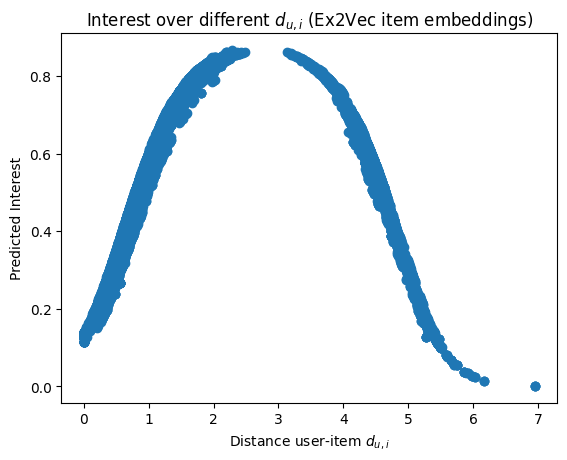

In [23]:
plt.scatter(distances.detach().cpu().numpy(), interests.detach().cpu().numpy())

plt.ylabel('Predicted Interest')
plt.xlabel('Distance user-item $d_{u,i}$')
plt.title('Interest over different $d_{u,i}$ (Ex2Vec item embeddings)')

## Ex2Vec Figure 2 (with GRU4Rec item embds)

In [25]:
# load ex2vec best parameters and use them as config
config_gruembds = config = {
    "alias": 'ex2vec_gruembds_finaltrain_DEL',
    "num_epoch": int(ex2vec_config['num_epoch']),
    "batch_size": int(ex2vec_config['batch_size']),
    "optimizer": 'adam',
    "lr": float(ex2vec_config['learning_rate']),
    "rmsprop_alpha": float(ex2vec_config['rmsprop_alpha']),
    "momentum": float(ex2vec_config['momentum']),
    "n_users": 3623,
    "n_items": 879,
    "latent_dim": 64,
    "num_negative": 0,
    "l2_regularization": float(ex2vec_config['l2_regularization']),
    "use_cuda": True,
    "device_id": 0,
    "pretrain": True,
    "pretrain_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/ex2vec_gruembds_FULL_finaltrain_trial19__BS512LR0.00014455048679195258L_DIM64N_EP50_Epoch49_f10.6004.pt",
    "model_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt",
    "chckpt_dir":"/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt",
}

# instantiate ex2vec model and set to eval mode for inference
ex2vec_gruembds_pre = Ex2VecEngine(config_gruembds, '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/')
ex2vec_gruembds_pre.model.eval()

/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/ex2vec.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ex2vec_pre.load_state_dict(torch.load(config['pretra

Ex2Vec(
  (user_lamb): Embedding(3623, 1)
  (user_bias): Embedding(3623, 1)
  (item_bias): Embedding(879, 1)
  (embedding_user): Embedding(3623, 64)
  (embedding_item): Embedding(879, 64)
  (logistic): Sigmoid()
  (tanh): Tanh()
)

In [26]:
interests_gruembds, distances_gruembds = ex2vec_gruembds_pre.model(torch.tensor(users).cuda(), torch.tensor(items).cuda(), torch.tensor(padded_rel_ints).cuda())

Text(0.5, 1.0, 'Interest over different $d_{u,i}$ (GRU4Rec item embeddings)')

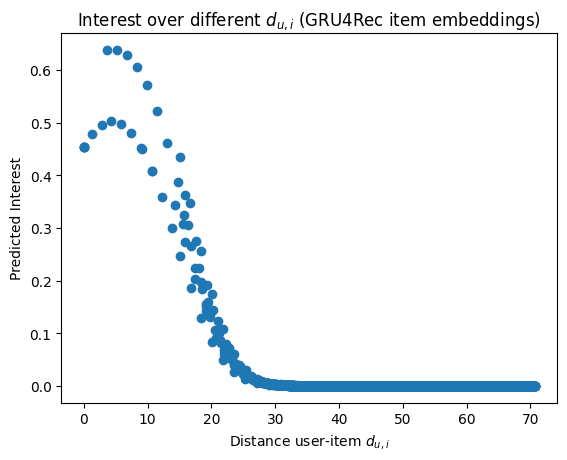

In [27]:
plt.scatter(distances_gruembds.tolist(), interests_gruembds.tolist())

plt.ylabel('Predicted Interest')
plt.xlabel('Distance user-item $d_{u,i}$')
plt.title('Interest over different $d_{u,i}$ (GRU4Rec item embeddings)')